# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). The data is sampled for you to something more manageable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, add comments and conclusions about your findings and describe anything you want to analyze in the future.

## Challenge Objectives
Successfully complete all these objectives to earn full credit. 

**Successful completion is defined as passing all the unit tests in each objective.**  

Each unit test that you pass is 1 point. 

There are 5 total possible points in this sprint challenge. 


There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on Yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

____

# Before you submit your notebook you must first

1) Restart your notebook's Kernel

2) Run all cells sequentially, from top to bottom, so that cell numbers are sequential numbers (i.e. 1,2,3,4,5...)
- Easiest way to do this is to click on the **Cell** tab at the top of your notebook and select **Run All** from the drop down menu. 

3) **Comment out the cell that generates a pyLDAvis visual in objective 4 (see instructions in that section).** 
____

### Part 0: Import Necessary Packages
For this section, you will need to import:
- `spacy` 
- `Pandas`
- `Seaborn`
- `Matplotlib`
- `NearestNeighbors`
- `Pipeline` 
- `TfidfVectorizer`
- `KneighborsClassifier`
- `GridSearchCV`
- `corpora`
- `LdaModel`
- `gensim`
- `re`

> **Note: This assignment is optimized to work with these specific packages. You can use import different packages, but note that this may affect how CodeGrade works, and may cause CodeGrade to fail.**

In [128]:
# Import Block
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

import gensim
import gensim.corpora as corpora
import gensim.models.ldamodel as ldamodel

#import spacy

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [129]:
# Visible Testing
assert pd.__package__ == 'pandas'




### Part 0: Import Data

In [130]:


# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/bloominstituteoftechnology/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import data into a DataFrame named df
df = pd.read_json(data_url, lines=True) #lines param fixes trailing data error

df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [131]:
# Visible Testing
assert isinstance(df, pd.DataFrame), 'df is not a DataFrame. Did you import the data into df?'
assert df.shape[0] == 10000, 'DataFrame df has the wrong number of rows.'

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- Accept one document at a time
- Return a list of tokens

You are free to use any method you have learned this week.

In [132]:
# Optional: Consider using spaCy in your function. The spaCy library can be imported by running this cell.
# A pre-trained model (en_core_web_sm) has been made available to you in the CodeGrade container.
# If you DON'T need use the en_core_web_sm model, you can comment it out below.

#nlp = spacy.load('en_core_web_sm')

In [133]:
# # Accurate version - slow!
# def tokenize(doc):
#     """cleans data via regex and sends to spacy nlp to tokenize"""

#     # replace newlines
#     doc = doc.replace("\\n", ' ')
#     # remove non-alphanumeric
#     doc = re.sub("[^a-zA-Z0-9]", " ", doc) 
#     # remove multiple white spaces
#     doc = re.sub("[ ]{2,}", " ", doc)
#     # case normalize and strip extra white spaces
#     doc = doc.strip().lower()

#     # spacy processing
#     s_tokens = nlp(doc)
#     return [t.lemma_ for t in s_tokens if (~t.is_stop) & (len(t.lemma_) > 1)]

In [134]:
# Messy version - faster

# sets are slightly faster and take care of accidental duplicates from manually copying output
StopWordsSimple = set(['the', 'i', 'to', 'and', 'a', 'was', 'in', 'of','it', 'is', 'we', 'for',
                        'with', 'my', 's', 't', 'he', 'that', 'but', 'had', 'you', 'on', 'us',
                        'this', 'were', 'our', 'there', 'place', 'are', 'have', 'they', 'be', 'so',
                        'me', 'at', 'if', 'from', 'can', 'not', 'get', 'like', 'all', 'she', 'or',
                        'very', 'them', 'would', 'an', 'about', 'get', 'their', 'your', 'just', 'has',
                        'here', 'really', 'as', 'do', 'one', 'time', 'no', 'also', 'could', 'been'])

def tokenize(doc):
    """cleans data via regex and attempts to remove stopwords as it tokenizes"""
    # replace newlines
    doc = doc.replace("\\n", ' ')
    # remove non-alphanumeric
    doc = re.sub("[^a-zA-Z0-9]", " ", doc)
    # remove number values
    doc = re.sub("[0-9]", "", doc)
    # remove multiple white spaces
    doc = re.sub("[ ]{2,}", " ", doc)
    # case normalize and strip extra white spaces
    doc = doc.strip().lower()

    return [word for word in doc.split() if (word not in StopWordsSimple) & (len(word) > 2)]

In [135]:
'''Testing'''
assert isinstance(tokenize(df.sample(n=1)["text"].iloc[0]), list), "Make sure your tokenizer function accepts a single document and returns a list of tokens!"

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews (i.e. create a doc-term matrix).
    * Name that doc-term matrix `dtm`

In [136]:
%%time

tvect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, 
                            stop_words='english', max_features=100)
tvect.fit(df['text'])
dtm = tvect.transform(df['text'])

C:\Users\Jeff\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 3.33 s



2. Write a fake review. Assign the text of the review to an object called `fake_review`. 
3. Query the fake review for the 10 most similar reviews, print the text of the reviews. 
    - Given the size of the dataset, use `NearestNeighbors` model for this. Name the model `nn`.

In [137]:
# Create and fit a NearestNeighbors model named "nn"

nn = NearestNeighbors(n_neighbors=10, algorithm='auto')
nn.fit(dtm)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [138]:
'''Testing.'''
assert nn.__module__ == 'sklearn.neighbors._unsupervised', ' nn is not a NearestNeighbors instance.'
assert nn.n_neighbors == 10, 'nn has the wrong value for n_neighbors'

In [139]:
# Create a fake review and find the 10 most similar reviews

# based on a real review, let's see if it is in the sample!
fake_review = "I ate there about 3 hours ago. Npw I have diarrhea. As far as Chinese buffets go, this one is pretty good"
fake_review_vector = tvect.transform([fake_review])

nn_distance, nn_index = nn.kneighbors(fake_review_vector, n_neighbors=10)

# display resulting reviews
for review_index in nn_index:
    print(df['text'][review_index])

6781    First time here Ashley was my sever. She was p...
4663    Spendy for breakfast but still good food.  Mus...
5207    Food is good. Pretty similar to the Texas Rudy...
5154    The food was pretty good, not like OMG this is...
9853    I went to this buffet for lunch, there was a l...
744     Pretty damn good. I had the Fettuccine Carbona...
8097    Pretty pricy food but last time I was here it ...
8960    Consistently good restaurant from a perspectiv...
7855    Service was quick and friendly (we could have ...
2137    The XLB are pretty good. \n\nApart from that, ...
Name: text, dtype: object


In [140]:
# Visible Testing
assert isinstance(fake_review, str), "Did you write a review in the correct data type?"

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier.
    - Use that pipeline to train a model to predict the `stars` feature (i.e. the labels). 
    - Use that pipeline to predict a star rating for your fake review from Part 2. 



2. Create a parameter dict including `one parameter for the vectorizer` and `one parameter for the model`. 
    - Include 2 possible values for each parameter
    - **Use `n_jobs` = 1** 
    - Due to limited computational resources on CodeGrader `DO NOT INCLUDE ADDITIONAL PARAMETERS OR VALUES PLEASE.`
    
    
3. Train the entire pipeline with a GridSearch
    - Name your GridSearch object as `gs`

In [141]:
# pipeline setup
tvect_pipe = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, 
                                stop_words='english', max_features=100)
rfc = RandomForestClassifier(random_state=42)
pipe = Pipeline([("vect", tvect_pipe), ("clf", rfc)])

# gridsearch setup
params = {
            "vect__max_df": (0.4, 0.6),
            "clf__max_depth": (20, 25)
}
gs = GridSearchCV(pipe, param_grid=params, n_jobs=1, cv=3)
gs.fit(df['text'], df['stars'])

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        nor

In [142]:
# predict star rating of fake review
# for reference, the one it was based on was three stars
fake_rating = gs.predict([fake_review])[0]
print(f"It's a {fake_rating}-Star review!")

It's a 4-Star review!


In [143]:
# Visible Testing
prediction = gs.predict(["This is your prediction statement."])[0]
assert prediction in df.stars.values, 'You gs object should be able to accept raw text within a list. Did you include a vectorizer in your pipeline?'

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Set num_topics to `5`
    - Name your LDA model `lda`
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

When you instantiate your LDA model, it should look like this: 

```python
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

```

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

## Note about  pyLDAvis

**pyLDAvis** is the Topic modeling package that we used in class to visualize the topics that LDA generates for us.

You are welcomed to use pyLDAvis if you'd like for your visualization. However, **you MUST comment out the code that imports the package and the cell that generates the visualization before you submit your notebook to CodeGrade.** 

Although you should leave the print out of the visualization for graders to see (i.e. comment out the cell after you run it to create the viz). 

### 1. Estimate a LDA topic model of the review text

* Use the `tokenize` function you created earlier to create tokens.
* Create an `id2word` object. 
> Hint: Use `corpora.Dictionary`
* Create a `corpus` object.
> Hint: Use `id2word.doc2bow`
* Instantiate an `lda` model. 

>> Remember to read the LDA docs for more information on the various class attributes and methods available to you in the LDA model: https://radimrehurek.com/gensim/models/ldamodel.html

In [144]:
# Do not change this value 
num_topics = 5

In [145]:
# create term mapping
df['tokens'] = df['text'].apply(tokenize)
id2word = corpora.Dictionary(df['tokens'])

In [146]:
# create corpus via doc2bow
corpus  = [id2word.doc2bow(tokens) for tokens in df['tokens']]

In [147]:
# instantiate lda model
lda = ldamodel.LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

#### Testing

In [148]:
# Visible Testing

assert lda.get_topics().shape[0] == 5, 'Did your model complete its training? Did you set num_topics to 5?'


#### 2. Create 1-2 visualizations of the results. Assign one of the visualizations to a variable called `visual_plot`.


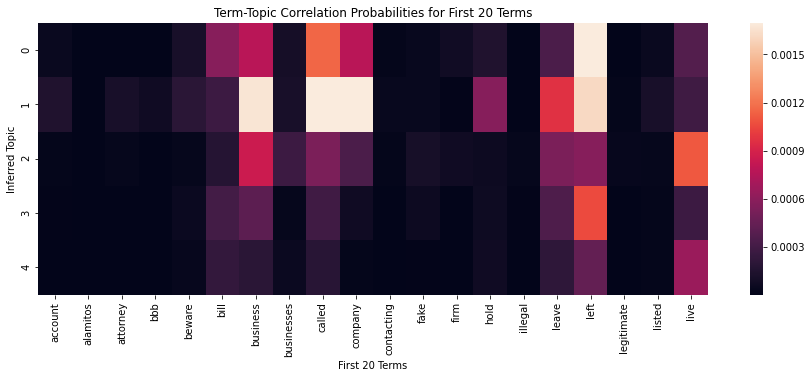

In [149]:

# Use a ploting tool of your choice to visualize your results. 

# 1. Generate seaborn heatmap of each terms's inferred relevance to topics
# unpack lda model for term-topic matrix, slice top n terms
tt_mtrx = lda.get_topics()
n = 20
tt_topn = [tt_mtrx[i][:n] for i in range(0,5)]

# convert term ids back to human-readable words
term_labels = []
for i in range(0, n):
    term_labels.append(id2word.get(i))

plt.figure(figsize=(15, 5))
visual_plot = sns.heatmap(tt_topn, xticklabels=term_labels, robust=True)
visual_plot.set_title(f"Term-Topic Correlation Probabilities for First {n} Terms")
visual_plot.set_xlabel(f"First {n} Terms")
visual_plot.set_ylabel("Inferred Topic")
plt.show()

From this basic heatmap of the first several terms we can see some of the workings of the LDA model in action:
- Each horizontal band represents one of the 5 topics we had the model assign term probabilities to; brighter sections indicate higher probability of that term associating with that topic.
- Dark vertical bands indicate terms not strongly associated with any topic, possibly due to being too infrequent or associated with a distant topic not considered in our range.
- Bright vertical bands show the opposite, words with strong association with all topics under considereation, due to frequency or interrelatedness of the topics.
- Most interesting are the terms with only one or two topic highlights; these are the keywords like "restaurant" that can strongly indicate whether a document is associated with a given topic.

In [150]:
# Bonus: show top words for each topic inferred
for x in range(0, num_topics):
    topterms = lda.get_topic_terms(x, topn=10)
    pterms = []
    for y in range(0, 10):
        pterms.append(id2word.get(topterms[y][0]))
    print(pterms)

['back', 'service', 'when', 'food', 'her', 'great', 'did', 'out', 'will', 'good']
['out', 'when', 'what', 'will', 'back', 'because', 'service', 'said', 'after', 'even']
['great', 'service', 'food', 'staff', 'good', 'room', 'back', 'out', 'best', 'will']
['good', 'food', 'great', 'out', 'what', 'some', 'best', 'service', 'pizza', 'other']
['food', 'good', 'great', 'service', 'chicken', 'delicious', 'which', 'ordered', 'menu', 'well']


This term list is't especially useful without good stop word removal and lemmatization, but even still we can see some vague trends in some of the lists:
- The term 'hair' appears uniquely in the third list, indicating that topic might be grouping together the Yelp reviews for services such as salons.
- 'chicken' and 'sauce' appear in the fourth list, 'service' appears in the fifth, while 'food' appears in both, indicating the model may be distinguishing fast-food takeout (list 4) from sit-down restaurants (list 5)

In [153]:
# #2. pyLDAvis section - to be removed
# import pyLDAvis
# import pyLDAvis.gensim

# pyLDAvis.enable_notebook()
# vis_pylda = pyLDAvis.gensim.prepare(lda, corpus, id2word)
# vis_pylda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.104401 -0.001722       1        1  31.377033
1      0.069984  0.030321       2        1  27.580436
2      0.032739 -0.074202       3        1  14.658167
3     -0.042824  0.021779       4        1  13.787866
0      0.044501  0.023825       5        1  12.596497, topic_info=           Term         Freq        Total Category  logprob  loglift
247       great  4265.000000  4265.000000  Default  30.0000  30.0000
171        food  4958.000000  4958.000000  Default  29.0000  29.0000
41         good  4733.000000  4733.000000  Default  28.0000  28.0000
539         her  1311.000000  1311.000000  Default  27.0000  27.0000
457       pizza   760.000000   760.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
107        only   260.257268  2078.768702   Topic5  -5.6452  -0.0061
246       going   214.858564  1146.646938   Topic5  -5.8369   0.3971
418  definitely   218.514385  1427.025265   Topic5  -5.8200   0.1953
37         what   227.091536  2397.722606   Topic5  -5.7815  -0.2852
701        some   222.077917  2208.065279   Topic5  -5.8039  -0.2251

[491 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
5074       5  0.936461    acai
5249       3  0.917303  accent
282        1  0.200731   after
282        2  0.412932   after
282        3  0.098645   after
...      ...       ...     ...
8873       4  0.028255    yoga
8873       5  0.028255    yoga
10397      3  0.897061    yuck
10397      4  0.056066    yuck
13145      1  0.983048     yuk

[1271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

With the initial default relevance value the pyLDAvis results are similar to what we inferred from the top term lists. However, by applying some term reduction by setting λ to about 0.2 on the slider we get some much more interesting results:
- Based on the relevant terms displayed, topic 2 seems to have clustered together reviews for nail salons and car mechanics, possibly due to words such as 'appointment' and 'call' appearing commonly in both.
- Topic 5 appears to group together hair stylists and related services (2 of the 3 top terms are 'hair' and 'stylist') but also some other misc. services (second term: 'gluten'??) for unclear reasons.
- Topics 1, 3, and 4 all intersect because they share a general food theme, but further term frequency indicates that topic 1 is attempting to group reviews for bars and restaurants (terms: 'bar', 'restaurant', 'service'), topic 3 is grouping hotel reviews (terms: 'hotel', 'room', 'pool'), and finally topic 4 is grouping reviews for purely food (ie. from fast-food takeout) based on the preponderance of food-specific terms ('chicken', 'taco')

In [152]:
# Visible Testing
assert visual_plot.__module__ == 'matplotlib.axes._subplots', "You must create and assign to visual_plot a visualization"
